# VAE Variational Autoencoder

import needest modules

In [18]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [19]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 

from tqdm import tqdm
import matplotlib.pyplot as plt

from VAE.model import VAE
from VAE.data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler

prepare dataset for training

In [20]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_robot_32_25.pt')

/tmp/ipykernel_2758/2843715136.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/wei

In [21]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/ROBO/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = ResumableRandomSampler(train_dataset)
#sampler.set_state(checkpoint['sampler_state'])
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           shuffle=False,
                           sampler=sampler,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [22]:
print("Len of trainloader: ",len(train_loader))


Len of trainloader:  210


In [5]:
torch.save(sampler.get_state(), "test_samp.pth")

setup param's for VAE training

In [28]:
lr = 0.001
epochs = 75
latent_dim = 32

create model & optimizer with parametrs ^^^ 

In [31]:
model = VAE(latent_dim, batch_size=BATCH_SIZE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

<All keys matched successfully>

## OR

In [32]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

create train func 

In [33]:
import matplotlib.pyplot as p

In [34]:
def train(epoch):
        """
        train VAE model.

        Args:
        epoch (int): number of epoch.
        """

        x = next(iter(train_loader))
        model.train()
        print(f'Epoch {epoch} start')
        eval_loss = 0
        # Loop through all batches in the training dataset
        for i, data, in enumerate(tqdm(train_loader)):
                data = data.to(DEVICE)
                optimizer.zero_grad()
                
                recon_batch, mu, logvar = model(data)
                loss = model.loss_function(recon_batch, data, mu, logvar)
                eval_loss += loss
                
                loss.backward() # Compute the gradients with respect to the model parameters
                
                optimizer.step() # Update the model parameters using the optimizer

        torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':loss,
                        'epoch':epoch,
                        'full_model':model,
                        'sampler_state':sampler.get_state(),
                        },
                        f'weights/main/VAE_checkpoint_robot_{latent_dim}_{epoch}.pt')
        
        print(f"Avg loss: {loss:2f} \n")
        model.eval()
        recon_img, _, _ = model(x[:1].to(DEVICE))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        f = p.imshow(img)
        p.show()


train model with logging on mlflow 

Epoch 25 start


 94%|█████████▍| 197/210 [00:49<00:03,  3.96it/s]


Avg loss: 0.497953 



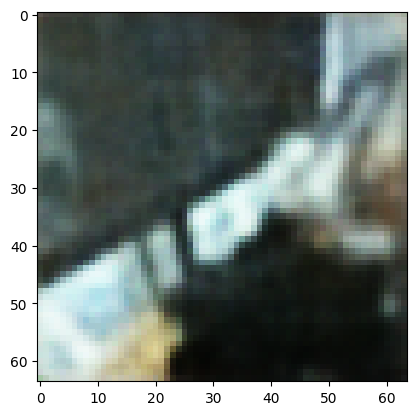

Epoch 26 start


 94%|█████████▍| 197/210 [00:51<00:03,  3.84it/s]


Avg loss: 0.515485 



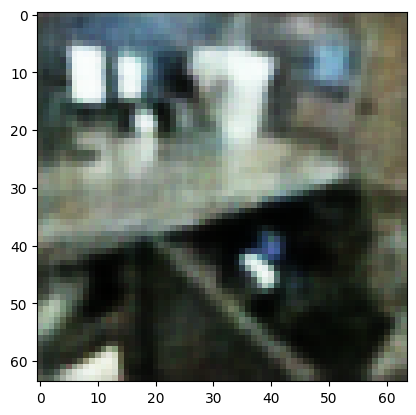

Epoch 27 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.78it/s]


Avg loss: 0.497739 



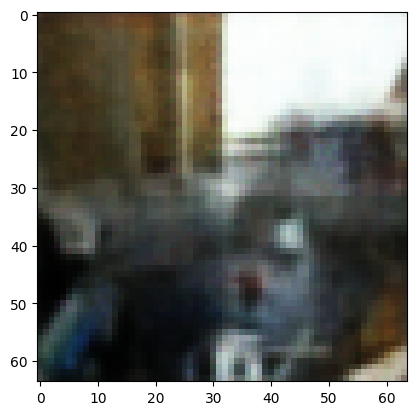

Epoch 28 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.75it/s]


Avg loss: 0.511731 



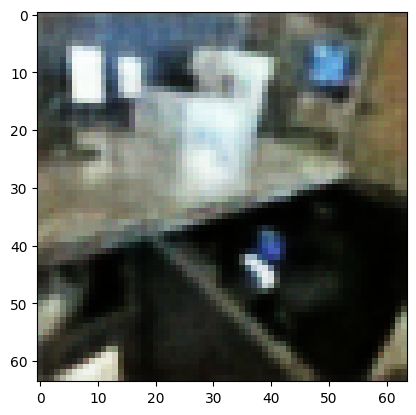

Epoch 29 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.500981 



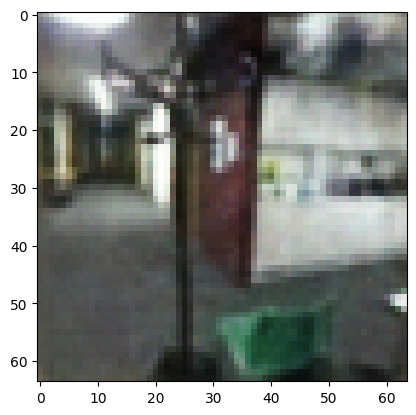

Epoch 30 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.520589 



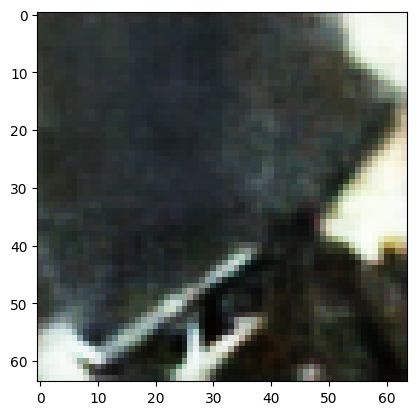

Epoch 31 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.495077 



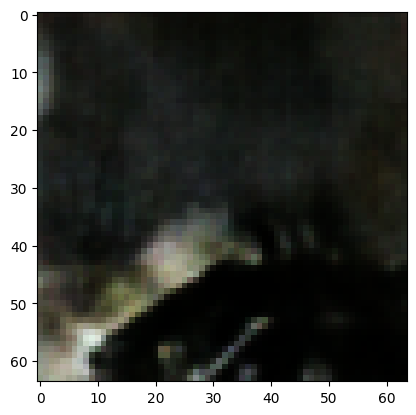

Epoch 32 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.516479 



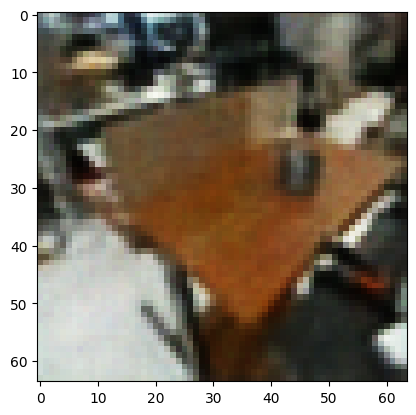

Epoch 33 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.498445 



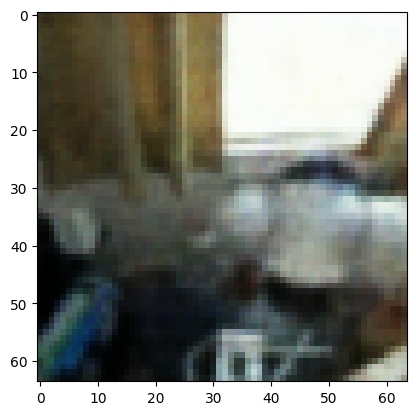

Epoch 34 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.523747 



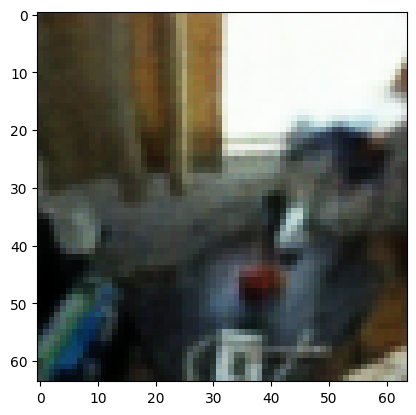

Epoch 35 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.502684 



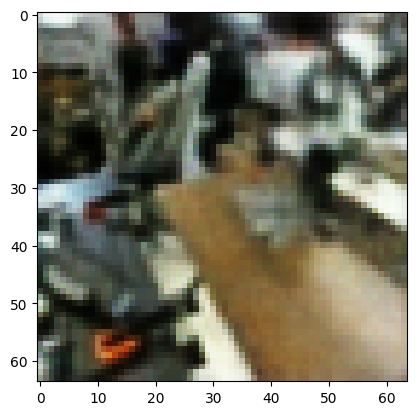

Epoch 36 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.529103 



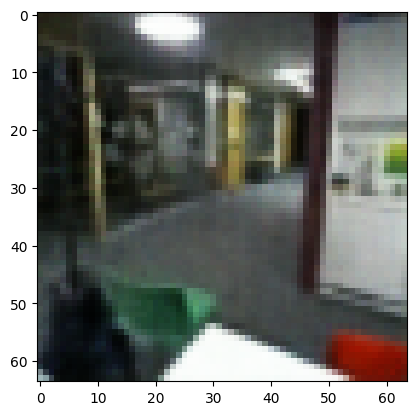

Epoch 37 start


 94%|█████████▍| 197/210 [00:52<00:03,  3.76it/s]


Avg loss: 0.521775 



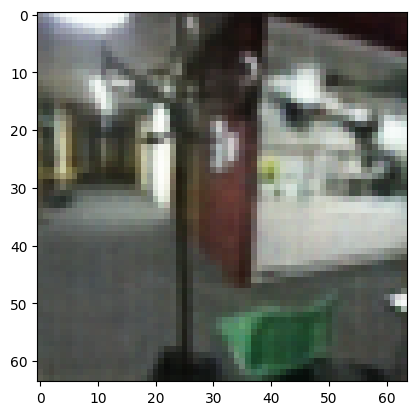

Epoch 38 start


 32%|███▏      | 67/210 [00:18<00:38,  3.72it/s]


KeyboardInterrupt: 

In [35]:
# Log model summary.|
with open("model_summary.txt", "w") as f:
    f.write(str(summary(model)))

for t in range(epoch, epochs+1):
    train(t)

In [38]:
x = next(iter(train_loader))

In [23]:
torch.onnx.export(model, x.to(DEVICE), "model.onnx", input_names=['image'], output_names=['image'])

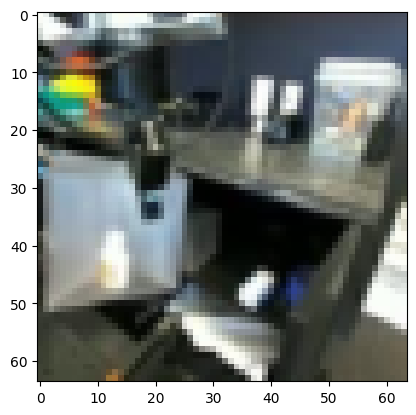

In [43]:
p.imshow(x[2].detach().cpu().numpy().transpose(1, 2, 0))

In [52]:
recon_img, _, _ = model(x[2].unsqueeze(0).to(DEVICE))
print(recon_img[0].shape)
img = recon_img[0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

torch.Size([1, 12288])


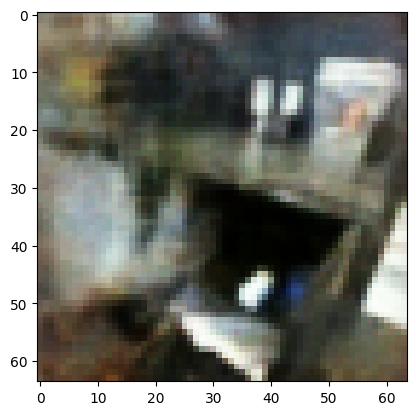

In [56]:
p.imshow(img)

## Test model

In [ ]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

test on exist image 

In [ ]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

transition of image to image

In [ ]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

generate image from nose

In [ ]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [36]:
torch.save(model.state_dict(), "ROBOT.pt")

In [17]:
reconstructed, _, _ = model(x[0][None, :, :, :].to(DEVICE))

In [18]:
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)


In [ ]:
reconstructed[0].shape